In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from langdetect import detect

import warnings; warnings.simplefilter('ignore')

# Categorizing Videos By Text

In [2]:
# Video Related Features
dfData = pd.read_csv('../data/cleaned_subset.csv')
dfImText = pd.read_csv('../data/image_text.csv')
dfNSFW = pd.read_csv('../data/virality_nsfw.csv')
dfLang = pd.read_csv('../data/data_and_language.csv')
dfClickBait = pd.read_csv('../data/clickbait.csv')
# Channel stats
dfChannel = pd.read_csv('../data/channelStats.csv')

In [3]:
dfNSFW.rename(columns={'video_id' : 'Id'}, inplace = True)

In [4]:
dfData = dfData.merge(dfLang,on='Id',how='left')
dfData = dfData.merge(dfImText,on='Id',how='left')
dfData = dfData.merge(dfNSFW,on='Id',how='left')
dfData = dfData.merge(dfClickBait,on='Id',how = 'left')
dfData = dfData.merge(dfChannel,on='Channel Id',how='left')


In [5]:
dfData = dfData[dfData['channelVideoCount']<2000]
dfData = dfData[dfData['subscriberCount'] >0]
dfData = dfData[dfData['Lang']=='en']

In [6]:
dfData.head()

,Id,Title,Description,LikeCount,DislikeCount,ViewCount,FavoriteCount,CommentCount,PublishedAt,Channel Id,...,Thumbnail Default,Lang,ImageText,ContainsText,nsfw_score,Title-Clickbait,publishedAt,subscriberCount,channelVideoCount,channelViewCount
0,AUzyaHo0QQc,b'300 pushups a day for 20 days!! - Results!!',b'**NEW** (2016) Abs Workout for 30 Days | htt...,40408,10312,13577683,0,8236,2010-07-22T10:28:30.000Z,UCPE_dNzOtjpP0vUA6papYaw,...,b'https://i.ytimg.com/vi/AUzyaHo0QQc/default.jpg',en,"{u'regions': [], u'orientation': u'NotDetected...",False,0.503699,0.923196,2009-12-22T03:47:24.000Z,47571,23,16245729
1,1Zgtdb7jp60,b'John Cena - gym',"b""Follow John Cena on twitter: http://www.twit...",37867,1486,9986096,0,2563,2012-02-20T13:55:03.000Z,UCpAxDQTpPNgc6kFiBRNO_1A,...,b'https://i.ytimg.com/vi/1Zgtdb7jp60/default.jpg',en,"{u'regions': [], u'orientation': u'NotDetected...",False,0.911593,0.106193,2011-11-11T20:58:03.000Z,109298,6,47779958
2,1Sfii7rnkJQ,b'Bodybuilding Motivation - No Time To Waste',"b""Follow me:\nhttp://instagram.com/shaqx.bb\nh...",17688,1291,8532402,0,1515,2012-01-18T15:06:01.000Z,UC3uDucFPe-E0I6CfxtHWZ6w,...,b'https://i.ytimg.com/vi/1Sfii7rnkJQ/default.jpg',en,"{u'regions': [], u'orientation': u'NotDetected...",False,0.263383,0.155738,2011-07-09T16:13:17.000Z,218558,19,75698414
3,UUwSKJjx9Go,b'Most Powerful Home Chest Workout Ever : Buil...,b'http://www.6weeksixpack.com This is one of t...,46293,2589,8301027,0,1490,2013-10-17T21:56:53.000Z,UCsiNPbLbwZk43FOCRrdKBlA,...,b'https://i.ytimg.com/vi/UUwSKJjx9Go/default.jpg',en,"{u'regions': [], u'orientation': u'NotDetected...",False,0.569090,0.075479,2006-08-07T08:12:53.000Z,1145468,585,186804665
4,Yl3NGvna2KA,b'Greg Plitt Best of The Best Workout Video Pr...,b'SIGN UP TODAY - http://bit.ly/jointheranks\r...,24784,1134,7141821,0,575,2011-03-30T18:57:57.000Z,UCU6WaCIOCL_eToBcsBYFwAQ,...,b'https://i.ytimg.com/vi/Yl3NGvna2KA/default.jpg',en,"{u'regions': [], u'orientation': u'NotDetected...",False,0.287760,0.351647,2009-10-24T03:18:10.000Z,158091,22,9908854


# Feature Creation using Title and Description Text

## Looking at Categorical Workouts

In [7]:
# Conver to lower case 
dfData['Title'] = dfData['Title'].str.lower()


# How To
dfData['HowTo'] = (dfData['Title'].str.contains('how')  | 
                       dfData['Tags'].str.contains('how'))

# Motivational
dfData['Motivation'] = (dfData['Title'].str.contains('motivation')  | 
                       dfData['Tags'].str.contains('motivation')  
                      )


# Transformation
dfData['Transform'] = (dfData['Title'].str.contains('transform')  | 
                       dfData['Tags'].str.contains('transform')  
                      )

# Abs Workout
dfData['Abs Video'] = (dfData['Title'].str.contains('abs')  | 
                       dfData['Title'].str.contains('six') | 
                       dfData['Title'].str.contains(' 6') | 
                       dfData['Title'].str.contains('abdomen') |
                       dfData['Tags'].str.contains('abs')  | 
                       dfData['Tags'].str.contains('six') | 
                       dfData['Tags'].str.contains(' 6') | 
                       dfData['Tags'].str.contains('abdomen') 
                      )
        
# Chest Workout
dfData['Chest Video'] = (dfData['Title'].str.contains('chest')  |
                         dfData['Title'].str.contains('pushup') | 
                         dfData['Title'].str.contains('bench') | 
                         dfData['Title'].str.contains('bench') | 
                         dfData['Title'].str.contains('push up') |
                         dfData['Title'].str.contains('dumbell press') |
                         dfData['Tags'].str.contains('chest')  |
                         dfData['Tags'].str.contains('pushup') | 
                         dfData['Tags'].str.contains('bench') | 
                         dfData['Tags'].str.contains('bench') | 
                         dfData['Tags'].str.contains('push up') |
                         dfData['Tags'].str.contains('dumbell press'))

# Back Workouts 
dfData['Back Video'] = (dfData['Title'].str.contains('back') | 
                        dfData['Title'].str.contains('pull up') | 
                        dfData['Title'].str.contains('chin up')  | 
                        dfData['Title'].str.contains('deadlift') | 
                        dfData['Tags'].str.contains('back') | 
                        dfData['Tags'].str.contains('pull up') | 
                        dfData['Tags'].str.contains('chin up')  | 
                        dfData['Tags'].str.contains('deadlift'))

# Leg Workouts
dfData['Legs Video'] = (dfData['Title'].str.contains('leg') | 
                        dfData['Title'].str.contains('squat') | 
                        dfData['Title'].str.contains('butt') | 
                        dfData['Title'].str.contains('quad') | 
                        dfData['Title'].str.contains('calve') |
                       dfData['Tags'].str.contains('leg') | 
                        dfData['Tags'].str.contains('squat') | 
                        dfData['Tags'].str.contains('butt') | 
                        dfData['Tags'].str.contains('quad') | 
                        dfData['Tags'].str.contains('calve') )

# Arm Workout
dfData['Arm Video'] = (dfData['Title'].str.contains('shoulder') | 
                       dfData['Title'].str.contains('arm') | 
                       dfData['Title'].str.contains('bicep')  |
                       dfData['Title'].str.contains('tricep') | 
                       dfData['Title'].str.contains('delt') |
                       dfData['Tags'].str.contains('shoulder') | 
                       dfData['Tags'].str.contains('arm') | 
                       dfData['Tags'].str.contains('bicep')  |
                       dfData['Tags'].str.contains('tricep') | 
                       dfData['Tags'].str.contains('delt'))



In [8]:
dfData.loc[dfData['Abs Video'] == True , 'Category'] = 'Abs'
dfData.loc[dfData['Chest Video'] == True , 'Category'] = 'Chest'
dfData.loc[dfData['Back Video'] == True, 'Category'] = 'Back'
dfData.loc[dfData['Legs Video'] == True, 'Category'] = 'Legs'
dfData.loc[dfData['Arm Video'] == True, 'Category'] = 'Arms'
dfData.loc[dfData['Motivation'] == True, 'Category'] = 'Motivation'
dfData.loc[dfData['HowTo'] == True, 'Category'] = 'HowTo'
dfData.loc[dfData['Motivation'] == True, 'Category'] = 'Motivation'
dfData.loc[dfData['Transform'] == True, 'Category'] = 'Transform'

In [9]:
#dfData = dfData.drop(['Abs Video', 'Chest Video','Back Video','Legs Video', 'Arm Video'], axis =1 )
dfData[dfData['Category'].isnull()].shape[0]

2971

In [10]:
dfData = dfData[dfData['Category'].notnull()]

In [11]:
absVid = dfData[dfData['Category'] == 'Abs']
chestVid = dfData[dfData['Category'] == 'Chest']
backVid = dfData[dfData['Category'] == 'Back']
legsVid = dfData[dfData['Category'] == 'Legs']
armsVid = dfData[dfData['Category'] == 'Arms']

print "Number of Abs Related Videos: " + str(absVid.shape[0])
print "Number of Chest Related Videos: " + str(chestVid.shape[0])
print "Number of Back Related Videos: " + str(backVid.shape[0])
print "Number of Leg Related Videos: " + str(legsVid.shape[0])
print "Number of Arm Related Videos: " + str(armsVid.shape[0])

Number of Abs Related Videos: 244
Number of Chest Related Videos: 234
Number of Back Related Videos: 314
Number of Leg Related Videos: 631
Number of Arm Related Videos: 621


## Maybe just Body Part Videos

In [12]:
#dfData = dfData[dfData['Category'].notnull()]
#dfData.shape[0]

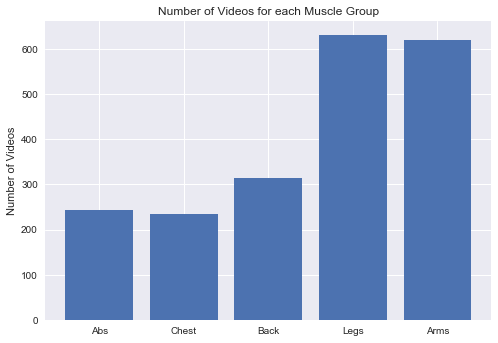

In [13]:
yCols = ['Abs', 'Chest', 'Back', 'Legs', 'Arms']
xCols = [absVid.shape[0], chestVid.shape[0], backVid.shape[0], legsVid.shape[0], armsVid.shape[0]]
y = np.arange(len(yCols))
plt.bar(y, xCols,align = 'center')
plt.xticks(y,yCols)
plt.ylabel("Number of Videos")
plt.title("Number of Videos for each Muscle Group")

## Observation
Legs/Abs/Arms being the most since they target both a guy/girl audience

## Understanding View Distribution

Category
Motivation    160787.713904
Chest         144898.914530
Transform     118548.230303
HowTo          86320.269476
Abs            83654.860656
Arms           57989.167472
Back           52984.429936
Legs           36815.242472
Name: ViewCount, dtype: float64


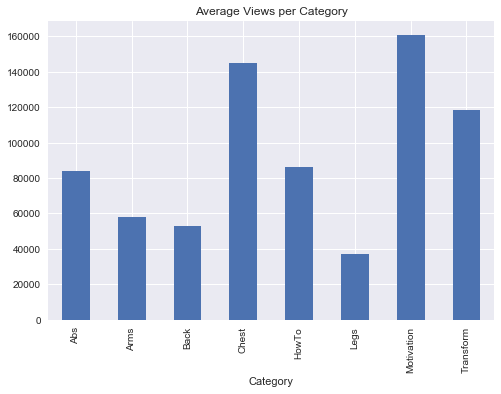

In [14]:
dfData.groupby('Category').ViewCount.mean().plot(kind="bar")
print(dfData.groupby('Category').ViewCount.mean().sort_values(ascending = False))
plt.title("Average Views per Category")
plt.show()

Category
Transform     869.060606
Motivation    719.604278
HowTo         698.176245
Chest         592.914530
Abs           577.483607
Arms          449.909823
Legs          365.470681
Back          308.082803
Name: LikeCount, dtype: float64


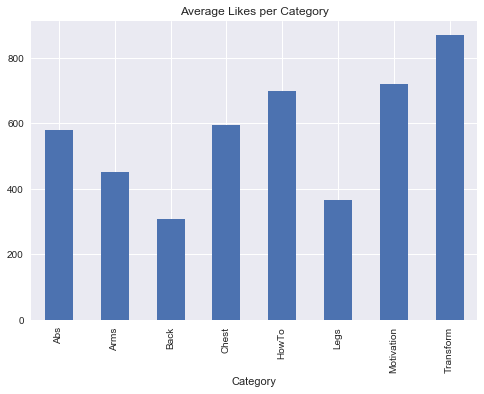

In [15]:
dfData.groupby('Category').LikeCount.mean().plot(kind="bar")
print(dfData.groupby('Category').LikeCount.mean().sort_values(ascending = False))
plt.title("Average Likes per Category")
plt.show()

Category
Transform     173.654545
Chest          94.098291
HowTo          92.650064
Abs            83.401639
Motivation     77.767380
Back           71.636943
Arms           58.492754
Legs           53.797147
Name: CommentCount, dtype: float64


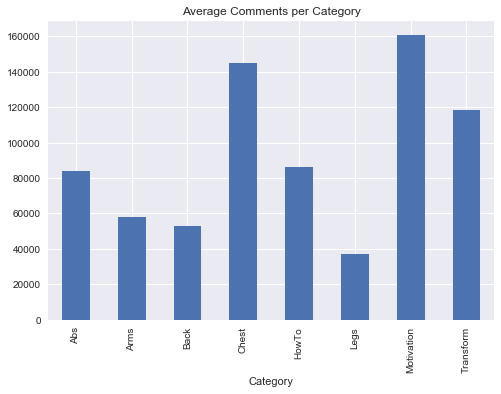

In [16]:
dfData.groupby('Category').ViewCount.mean().plot(kind="bar")
print(dfData.groupby('Category').CommentCount.mean().sort_values(ascending = False))
plt.title("Average Comments per Category")
plt.show()

## Observation

Despite Legs having more videos than chest/abs, it has the least amount of views and likes.
The most liked videos are chest and abs

### Categorizing by "Sponsored" and "Description Box" 

In [17]:
# Abs Workout
dfData['isSponsored'] = (dfData['Description'].str.contains('sponsored')  | 
                       dfData['Description'].str.contains('provided by'))

dfData['hasDiscount'] = (dfData['Description'].str.contains("discount") |
                        dfData['Description'].str.contains("code"))

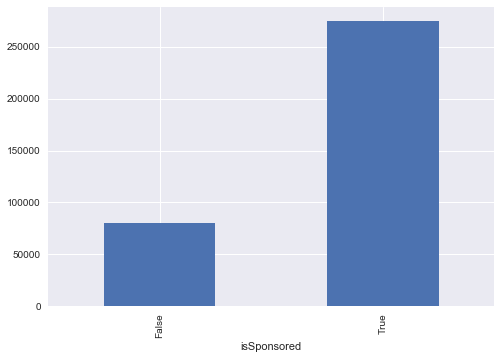

In [18]:
dfData.groupby('isSponsored').ViewCount.mean().plot(kind="bar")

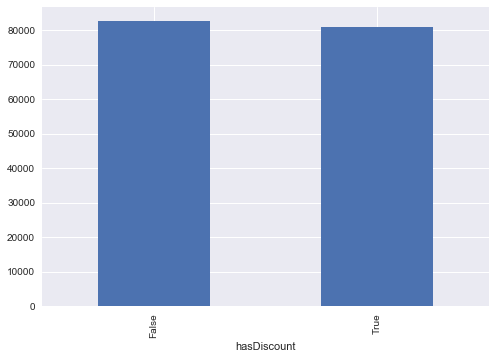

In [19]:
dfData.groupby('hasDiscount').ViewCount.mean().plot(kind="bar")

In [20]:
dfData['LikeDislikeRatio'] = dfData['LikeCount']/(dfData['LikeCount'] + dfData['DislikeCount'])

In [21]:
# Motivation
# Transformation
# Keywords: Ripped/Extreme/sexy/fat/intense
# BodyBuilding
# Tutorial/How To

In [22]:
dfData.columns

Index([u'Id', u'Title', u'Description', u'LikeCount', u'DislikeCount',
       u'ViewCount', u'FavoriteCount', u'CommentCount', u'PublishedAt',
       u'Channel Id', u'Channel Title', u'Tags', u'Thumbnail Default', u'Lang',
       u'ImageText', u'ContainsText', u'nsfw_score', u'Title-Clickbait',
       u'publishedAt', u'subscriberCount', u'channelVideoCount',
       u'channelViewCount', u'HowTo', u'Motivation', u'Transform',
       u'Abs Video', u'Chest Video', u'Back Video', u'Legs Video',
       u'Arm Video', u'Category', u'isSponsored', u'hasDiscount',
       u'LikeDislikeRatio'],
      dtype='object')

In [23]:
dfData.shape

(3366, 34)

In [38]:
def feature_engineer(dfData):
    dfData =dfData.drop(['Category','FavoriteCount','ImageText'],axis =1)
    dfData['is_english'] = dfData['Lang'].apply(lambda x: 1 if x=='en' else 0)
    dfData = dfData.drop('Lang', axis=1)
    
    dfData['is_Abs'] = dfData['Abs Video'].apply(lambda x: 1 if x==True else 0)
    dfData['is_Chest'] = dfData['Chest Video'].apply(lambda x: 1 if x==True else 0)
    dfData['is_Back'] = dfData['Back Video'].apply(lambda x: 1 if x==True else 0)
    dfData['is_Legs'] = dfData['Legs Video'].apply(lambda x: 1 if x==True else 0)
    dfData['is_Arms'] = dfData['Arm Video'].apply(lambda x: 1 if x==True else 0)
    dfData['ContainsText'] = dfData['ContainsText'].apply(lambda x: 1 if x==True else 0)
    dfData['isSponsored'] = dfData['isSponsored'].apply(lambda x: 1 if x==True else 0)
    dfData['hasDiscount'] = dfData['hasDiscount'].apply(lambda x: 1 if x==True else 0)
    dfData['PublishedYear'] = dfData['PublishedAt'].apply(lambda x: x[:4])
    dfData['ChannelAge'] =  dfData['publishedAt'].apply(lambda x: x[:4])
    dfData['channelViewCount'] = np.log(dfData['channelViewCount'])
    dfData['ContainsText'] = dfData['ContainsText'].fillna(0)
    dfData['nsfw_score'] = dfData['nsfw_score'].fillna(dfData['nsfw_score'].mean())
    dfData['Title-Clickbait'] = dfData['Title-Clickbait'].fillna(dfData['nsfw_score'].mean())
    dfData['LikeDislikeRatio'] = dfData['LikeCount']/(dfData['DislikeCount'] + dfData['LikeCount'])
    
    dfData['LikeDislikeRatio'] = dfData['LikeDislikeRatio'].replace(np.inf, np.nan)
    dfData['LikeDislikeRatio'] = dfData['LikeDislikeRatio'].fillna(0)
    dfData = dfData.drop(['Title','Description','PublishedAt','publishedAt','Channel Id','Channel Title','Tags','Thumbnail Default','Abs Video','Chest Video','Back Video','Legs Video','Arm Video'],axis = 1)
    
    return dfData

def drop_obvious_features(dfData):
    dfData = dfData.drop(['LikeCount','DislikeCount','CommentCount'],axis = 1)
    return dfData

def drop_engineered_features(dfData):
    dfData = dfData.drop(['nsfw_score','Title-Clickbait'],axis = 1)
    return dfData

In [25]:
df = feature_engineer(dfData)

In [26]:
df.columns

Index([u'Id', u'LikeCount', u'DislikeCount', u'ViewCount', u'CommentCount',
       u'ContainsText', u'nsfw_score', u'Title-Clickbait', u'subscriberCount',
       u'channelVideoCount', u'channelViewCount', u'HowTo', u'Motivation',
       u'Transform', u'isSponsored', u'hasDiscount', u'LikeDislikeRatio',
       u'is_english', u'is_Abs', u'is_Chest', u'is_Back', u'is_Legs',
       u'is_Arms', u'PublishedYear', u'ChannelAge'],
      dtype='object')

In [27]:
X, y = df.drop('ViewCount',axis = 1) , np.log(df['ViewCount'])

In [28]:
def checkForNull(X,y):
    X = X.as_matrix().astype(float)
    print "Check For Null Values"
    for i in range(0,len(df.columns)-1):
        print np.any(np.isnan(X[:,i]))
    print "Check for Pred:"
    y = y.as_matrix().astype(float)
    print np.any(np.isnan(y))

In [29]:
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, XGBRegressor


In [30]:
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.75, test_size=0.25)

train_X_id,train_X = train_X.Id, train_X.drop('Id',axis = 1)
test_X_id,test_X = test_X.Id, test_X.drop('Id',axis = 1)

In [31]:
reg = GradientBoostingRegressor()
reg.fit(train_X, train_y)
reg.score(test_X, test_y)

0.85616123335209249

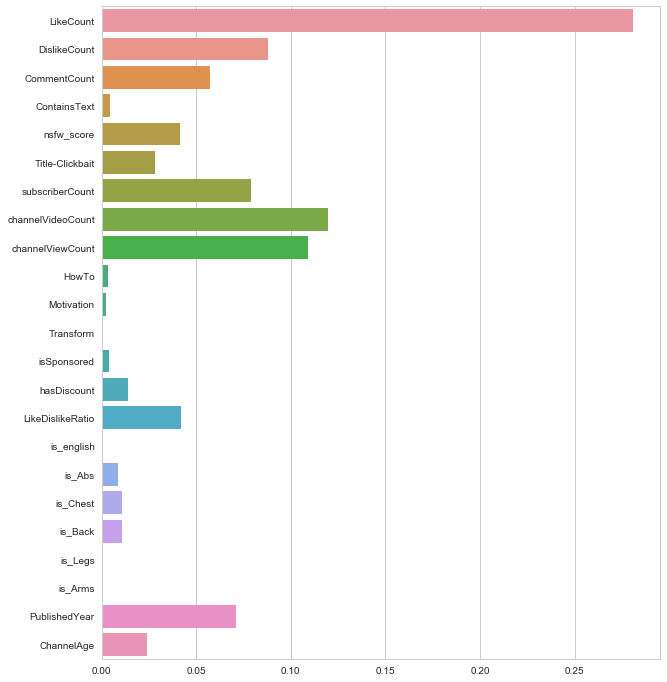

In [32]:
X = X.drop('Id', axis = 1)
sns.set_style('whitegrid')
plt.figure(figsize=(10,12))
sns.barplot(x=reg.feature_importances_, y=X.columns)

In [39]:
df = drop_engineered_features(drop_obvious_features(feature_engineer(dfData)))
X, y = df.drop(['ViewCount','LikeDislikeRatio'],axis=1), np.log(df['ViewCount'])

train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.75, test_size=0.25)

train_X_id,train_X = train_X.Id, train_X.drop('Id',axis = 1)
test_X_id,test_X = test_X.Id, test_X.drop('Id',axis = 1)

reg = GradientBoostingRegressor()
reg.fit(train_X, train_y)
reg.score(test_X, test_y)



0.46862774367814758

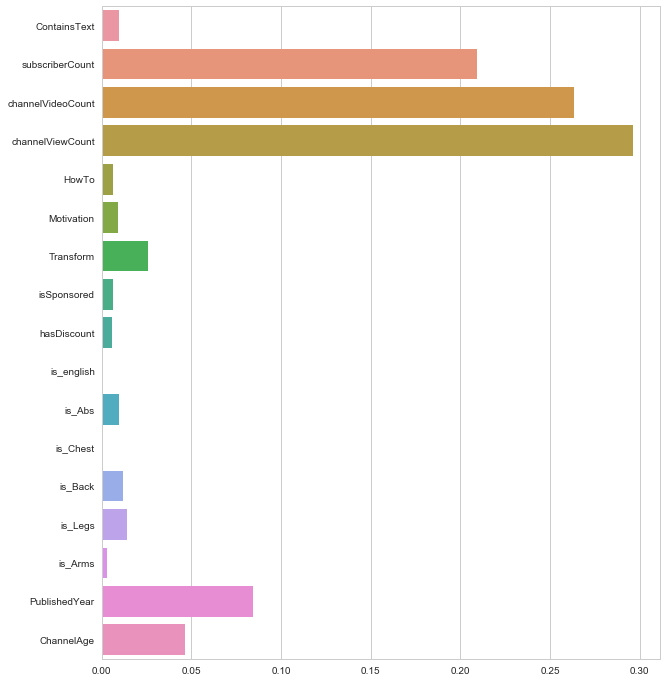

In [40]:
X = X.drop('Id',axis = 1)
sns.set_style('whitegrid')
plt.figure(figsize=(10,12))
sns.barplot(x=reg.feature_importances_, y=X.columns)

In [41]:
reg = XGBRegressor()
train_X['ChannelAge'] = train_X['ChannelAge'].astype(int)
test_X['ChannelAge'] = test_X['ChannelAge'].astype(int)
train_X['PublishedYear'] = train_X['PublishedYear'].astype(int)
test_X['PublishedYear'] = test_X['PublishedYear'].astype(int)
reg.fit(train_X, train_y)
reg.score(test_X, test_y)

0.47136331283325456

In [42]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import datasets, linear_model
reg = linear_model.LinearRegression()
train_X['ChannelAge'] = train_X['ChannelAge'].astype(int)
test_X['ChannelAge'] = test_X['ChannelAge'].astype(int)
train_X['PublishedYear'] = train_X['PublishedYear'].astype(int)
test_X['PublishedYear'] = test_X['PublishedYear'].astype(int)
reg.fit(train_X, train_y)
reg.score(test_X, test_y)

0.37626184691514208

In [43]:
from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor()
train_X['ChannelAge'] = train_X['ChannelAge'].astype(int)
test_X['ChannelAge'] = test_X['ChannelAge'].astype(int)
train_X['PublishedYear'] = train_X['PublishedYear'].astype(int)
test_X['PublishedYear'] = test_X['PublishedYear'].astype(int)
reg.fit(train_X, train_y)
reg.score(test_X, test_y)

0.42786519636415976